# Feature Selection Strategies

### Synopsis

This notebook is intended to illustare and compare several feature selection strategies on a synthetic dataset. The first part of the notebook will cover the creation of the dataset and the second part will cover each feature selection method.

### Contents

1. [Synthetic Data Creation](#makeclassification)
2. [Classification with Synthetic Data](#syn)
3. [Ridge Regression and LASSO](#ridge_lasso)
4. [Forward feature selection](#forward)
5. [Selection by ensemble of trees](#tree)
6. [Comparison](#comp)

## Imports and Setup

In [2]:
# imports
import numpy as np
import pandas as pd
from scipy import stats
from itertools import product, combinations
import warnings

# sklearn
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import ParameterGrid, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.datasets import make_classification

# Selectors
from utils.selectors import *

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')

%matplotlib inline

# Setup Seaborn
sns.set(rc={"figure.figsize": (10, 8), "font.size": 10})
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.0, rc={"lines.linewidth": 2.5})

## Understanding Synthethic Data Creation <a class="anchor" id="makeclassification"></a>

First, let's generate a low dimensional dataset for the sake of simplicity. We will use this data to visually inspect the nehavior of the `make_classification` function from `scikit-learn`.

The toy dataset contains 2 informative features, 1 non-informative (constructed from a linear combination of informative ones) and 1 random noise feature.

In [2]:
# Create data with 2 informative, 1 redundant and 1 non-informative features
X, y = make_classification(n_samples=500, n_features=4, n_informative=2, n_redundant=1, n_classes=2, 
                           n_clusters_per_class=2, class_sep=2.0, flip_y = 0.005, random_state=1234)

# Construct Dataframe and assign feature names
n_feats = 4
df_ = pd.DataFrame(X, columns=['f-'+str(i+1) for i in range(n_feats)])
df_['label'] = y

Let's plot the features distributions. From a scatter plot, we can see how they are distributed across the binary label. 

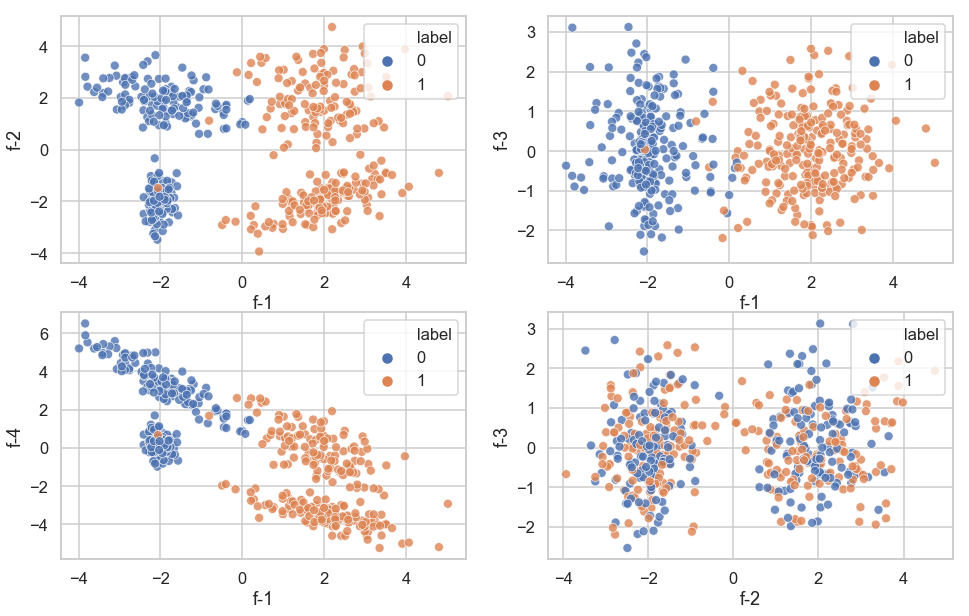

In [3]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sns.scatterplot(x='f-1', y='f-2', hue='label', data=df_, ax=ax[0,0], alpha=0.8)
sns.scatterplot(x='f-1', y='f-3', hue='label', data=df_, ax=ax[0,1], alpha=0.8)
sns.scatterplot(x='f-1', y='f-4', hue='label', data=df_, ax=ax[1,0], alpha=0.8)
sns.scatterplot(x='f-2', y='f-3', hue='label', data=df_, ax=ax[1,1], alpha=0.8)
plt.show()

We observe that:

* There is one random feature (`f-3`) which is just random noise
* There is one feature (`f-4`) which is a linear combination of others

Let's also use violin plots to inspect each feature separately

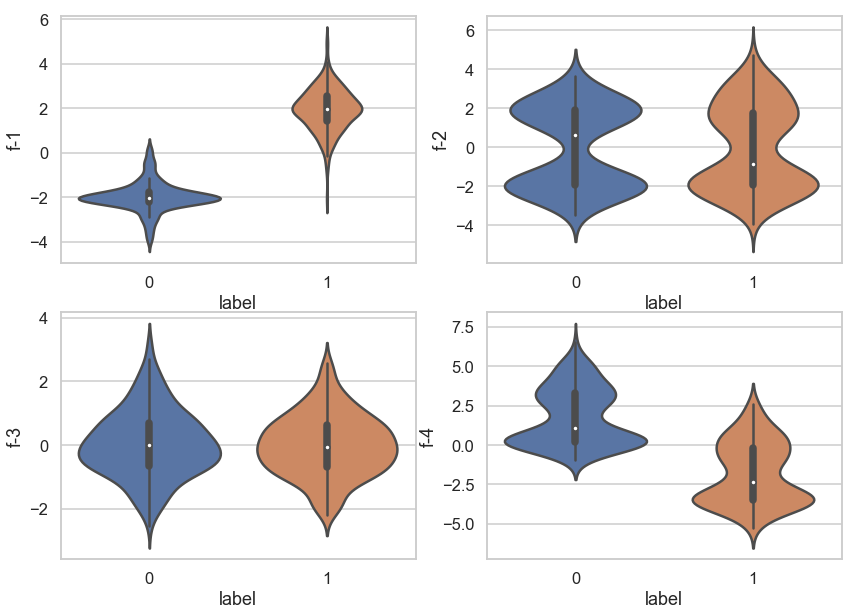

In [4]:
fig, ax = plt.subplots(2,2,figsize=(14,10))
sns.violinplot(data=df_, x='label', y='f-1', ax=ax[0,0],alpha=0.8)
sns.violinplot(data=df_, x='label', y='f-2', ax=ax[0,1],alpha=0.8)
sns.violinplot(data=df_, x='label', y='f-3', ax=ax[1,0],alpha=0.8)
sns.violinplot(data=df_, x='label', y='f-4', ax=ax[1,1],alpha=0.8)
plt.show()

As seen in the scatter plots, `f-3` is just random noise. `f-2` has also no discriminative capability, but it displays two distinct clusters. 

## Classification with Synthetic Data <a class="anchor" id="syn"></a>

Let's consider a more realistic case with 75 features, 25 of which are informative and 5 are redundant (constructed from linear combinations of informative features). Let us also split the data into a training and test sets:

In [5]:
# Create synthetic data
X, y = make_classification(n_samples=1000, n_features=75, n_informative=25, n_redundant=5, n_classes=2, 
                           n_clusters_per_class=2, class_sep=1.0, flip_y = 0.005, random_state=1234)

# Create training and test split (half of samples in test set)
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.5,stratify = y, random_state=12345)

Build dataframes from training and test data:

In [6]:
n_feats = 75
df_tr = pd.DataFrame(X_tr, columns=['f-'+str(i+1) for i in range(n_feats)])
df_tr['label'] = y_tr

df_ts = pd.DataFrame(X_ts, columns=['f-'+str(i+1) for i in range(n_feats)])
df_ts['label'] = y_ts

### Univariate Analysis

A simple way to visualize data with a large number of features is to plot p-values from univariate tests on each feature and an effect size on a scatter plot (similar to volcano plots).

The scatter plot is constructed as follows:

* y-axis: log10 of the p-value for unpaired t-test for each feature's potivive and negative label means
* x-axis: Misclassification rate for each feature (defined below)

Features corresponding to points closer to bottom-left corner (lower p-value and misclassification rate) have more discriminative power. Such plots allows us to determine "good" features easily


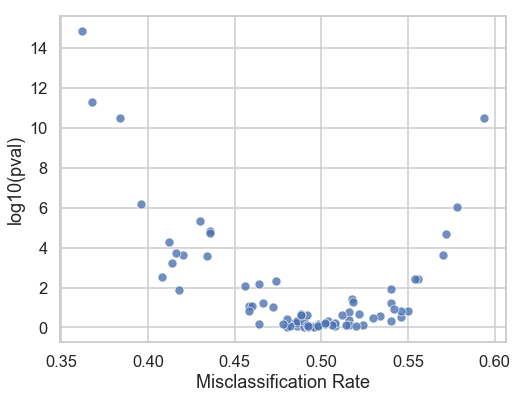

In [7]:
# Effect sizes and p-values from training data
df_v = volcano(df_tr)

fig = plt.figure(figsize=(8,6))
df_v['log10p'] = df_v['pval'].apply(lambda x: -np.log10(x))

sns.scatterplot(data=df_v, x='mc_rate', y='log10p', alpha=0.8)
plt.xlabel('Misclassification Rate')
plt.ylabel('log10(pval)')
plt.show()

Let's look at the best 4 features (on the top left corner)

In [8]:
# Top 10 features with highest (absolute) effect sizes
df_v[(df_v['log10p'] > 6) & (df_v['mc_rate'] < 0.4)]

,pval,mc_rate,log10p
f-23,4.926525e-12,0.367926,11.307459
f-28,6.341680e-07,0.395926,6.197796
f-33,3.204801e-11,0.384086,10.494199
f-34,1.369730e-15,0.362062,14.863365


### Ridge Regression and LASSO <a class="anchor" id="ridge_lasso"></a>

These are simple methods which will reduce the number of features automatically. Rigde Regression achieves reduction by lowering the effective degrees of freedom by shrinking the feature weights, while LASSO explicitly sets some of the weights to 0.

Let's perform Ridge Regression first:

In [9]:
# Ridge Regression (penatly='l2') training
skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l2', scoring = 'neg_log_loss',
                             n_jobs=-1)
clf_cv.fit(X_tr, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a1ec7ac88>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [10]:
# Predictions (train/test)
y_prob_tr = clf_cv.predict_proba(X_tr)
y_prob_ts = clf_cv.predict_proba(X_ts)

In [12]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3321 :: Test NLL = -0.4231
Train AUC = 0.9366 :: Test AUC = 0.8859


Let's compute the effective degrees of freedom (see [Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/))

$$ df({\lambda}) = {\rm Tr} \left[ {\bf X} \left( {\bf X}^T {\bf X} + \lambda {\bf 1} \right)^{-1} {\bf X}^T \right] $$

In [13]:
C_ = clf_cv.C_[0]
lam_ = 1.0 / C_
df_ridge = np.dot(np.dot(X_tr, np.linalg.inv(np.dot(X_tr.T, X_tr) + lam_*np.eye(n_feats))), X_tr.T).trace()

print("Ridge Regression effective d.o.f = {:.2f}".format(df_ridge))

Ridge Regression effective d.o.f = 62.70


Let's observe the effect of the hyper-parameter C on the weights of each feature:

In [14]:
# Save Ridge Regression weights for later use
weights_ridge = np.squeeze(clf_cv.coef_)

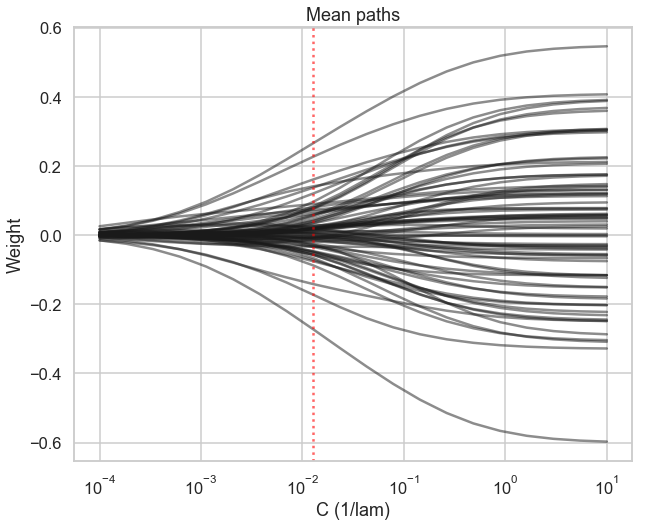

In [15]:
# Plot mean paths for each coefficient
fig = plt.figure(figsize=(10,8))

paths = np.mean(clf_cv.coefs_paths_[1], axis=0)
for i in range(n_feats+1):
    plt.plot(np.logspace(-4,1,20), paths[:,i], 'k-', alpha=0.5)

plt.xscale('log')
plt.axvline(clf_cv.C_[0], color='red', linestyle=':', alpha=0.6)
plt.xlabel("C (1/lam)")
plt.ylabel('Weight')
plt.title("Mean paths")
plt.show()
#plt.savefig('Ridge_path.png')

Now, let's train LASSO:

In [16]:
# LASSO Regression (penalty='l1') training
skf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state=12345)
clf_cv = LogisticRegressionCV(Cs = np.logspace(-4,1,20), cv = skf, penalty='l1', solver = 'liblinear',
                              scoring = 'neg_log_loss', n_jobs=-1)
clf_cv.fit(X_tr, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a21c9ee80>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l1',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='liblinear', tol=0.0001, verbose=0)

In [17]:
# Predict
y_prob_tr = clf_cv.predict_proba(X_tr)
y_prob_ts = clf_cv.predict_proba(X_ts)

In [18]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3569 :: Test NLL = -0.4153
Train AUC = 0.9239 :: Test AUC = 0.8910


LASSO shrinks some weights to zero explicitly:

In [19]:
weights_lasso = np.squeeze(clf_cv.coef_)
mask = weights_lasso != 0
selected_features_lasso = ['f-' + str(i+1) for i,c in enumerate(weights_lasso) if mask[i] !=0]
print("Number of features after LASSO = {:d}".format(len(selected_features_lasso)))

Number of features after LASSO = 21


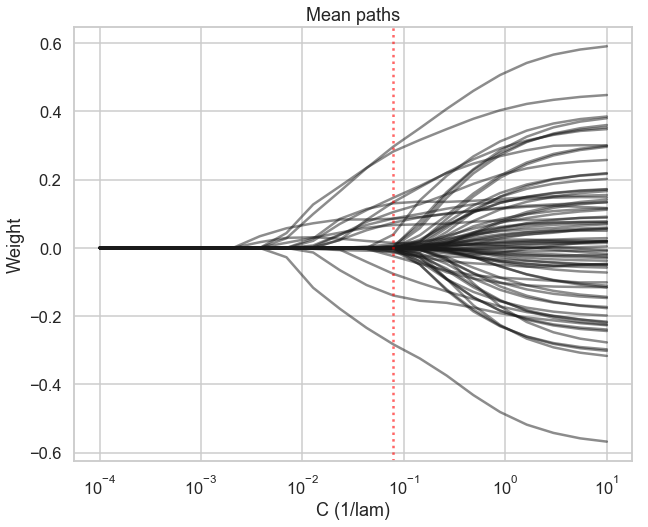

In [20]:
# Plot mean paths for each coefficient
fig = plt.figure(figsize=(10,8))

paths = np.mean(clf_cv.coefs_paths_[1], axis=0)
for i in range(n_feats+1):
    plt.plot(np.logspace(-4,1,20), paths[:,i], 'k-', alpha=0.5)

plt.xscale('log')
plt.axvline(clf_cv.C_[0], color='red', linestyle=':', alpha=0.6)
plt.xlabel("C (1/lam)")
plt.ylabel('Weight')
plt.title("Mean paths")
plt.show()
#plt.savefig('LASSO_path.png')

### Forward Feature Selection using Ridge Regression <a class="anchor" id="forward"></a>

Let's apply forward feature selection. We tune both the hyper-parameter C and the chosen feature at the same time in the CV cycles:

In [21]:
feature_list = ['f-'+str(i+1) for i in range(n_feats)]
rep_lg = forward_select_ridge(df_tr, feature_list, Cs = np.logspace(-4,1,20), n_max=30)

Selected feature = f-34 :: best C = 0.0428 :: current CV score = -0.6317
Selected feature = f-33 :: best C = 0.0428 :: current CV score = -0.5772
Selected feature = f-23 :: best C = 0.0785 :: current CV score = -0.5336
Selected feature = f-7 :: best C = 0.1438 :: current CV score = -0.4851
Selected feature = f-5 :: best C = 0.1438 :: current CV score = -0.4457
Selected feature = f-69 :: best C = 0.1438 :: current CV score = -0.4310
Selected feature = f-54 :: best C = 0.1438 :: current CV score = -0.4197
Selected feature = f-43 :: best C = 0.1438 :: current CV score = -0.4091
Selected feature = f-50 :: best C = 0.1438 :: current CV score = -0.4028
Selected feature = f-55 :: best C = 0.0785 :: current CV score = -0.3992
Selected feature = f-73 :: best C = 0.0785 :: current CV score = -0.3957
Selected feature = f-15 :: best C = 0.0785 :: current CV score = -0.3925
Selected feature = f-27 :: best C = 0.0785 :: current CV score = -0.3900
Selected feature = f-35 :: best C = 0.0785 :: current

From the log, we can see that the CV scores start to decrease after a while. Let's find the maximum position to determine the best set of features and C (optimized together):

In [22]:
nlls_forward = [sc for f,c,sc in rep_lg]
feat_lists = [f for f,c,sc in rep_lg]

idx_best = np.argmax(nlls_forward)
selected_features_forward = feat_lists[idx_best]
print("{:d}/{:d} features chosen".format(len(selected_features_forward),n_feats))

28/75 features chosen


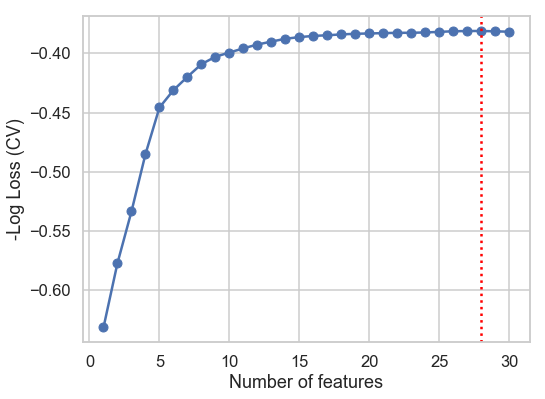

In [23]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(1,31), nlls_forward, 'b-o')
plt.axvline(28, color='red', linestyle = ':')
plt.xlabel('Number of features')
plt.ylabel('-Log Loss (CV)')
plt.show()
#plt.savefig('FFS.png')

Refit with the determined hyper-parameters and evaluate performance.

In [24]:
# Refit using best hyper-parameters
f_list_sk, c_best, _ = rep_lg[idx_best]

xx_tr = df_tr[f_list_sk]
xx_ts = df_ts[f_list_sk]
clf_fin = LogisticRegression(C=c_best, penalty='l2')
clf_fin.fit(xx_tr, y_tr)

# Predict
y_prob_tr = clf_fin.predict_proba(xx_tr)
y_prob_ts = clf_fin.predict_proba(xx_ts)

In [25]:
# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3300 :: Test NLL = -0.4307
Train AUC = 0.9336 :: Test AUC = 0.8822


In [26]:
# Forward selection weights
weights_forward = np.squeeze(clf_fin.coef_)

## Selection of Features by tree ensembles <a class="anchor" id="tree"></a>

The idea is to use a tree ensemble as a feature selector using the feature importances. While it is possible to use tree ensemble as the classifier itself, we will simply use the "important" features it determines in ridge regression. 

This approach provides a pre-filtering of features, and does not combine feature selection procedure with hyper-parameter tuning. Therefore, care must be taken to avoid selection bias (the boostrap procedure in Random Forest can mitigate some of it, since not all data is used for building trees).

In [27]:
# Random Forest for Feature selection
rf = RandomForestClassifier(n_estimators=500, max_features=10, n_jobs=-1)
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

By default, features that have importances smaller than the mean value will be removed (importance is measured by the average contribution from the feature to the decrease in Gini coefficient).

In [28]:
# Select features
selector = SelectFromModel(rf, prefit=True)
X_tr_new = selector.transform(X_tr)
X_ts_new = selector.transform(X_ts)

mask = list(selector.get_support())
selected_features_rf = [f for i,f in enumerate(range(n_feats)) if mask[i] == True]
selected_features_rf = list(map(lambda x: 'f-' + str(x), selected_features_rf))
print("Number of selected features = {:d}".format(len(selected_features_rf)))

Number of selected features = 23


Now that we have selected the features, let's use them to train a separate ridge regression classifier.

In [29]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12345)
clf = LogisticRegressionCV(Cs = np.logspace(-4,1,20), penalty='l2', cv=skf, scoring='neg_log_loss', n_jobs=-1)
clf.fit(X_tr_new, y_tr)

LogisticRegressionCV(Cs=array([1.00000e-04, 1.83298e-04, 3.35982e-04, 6.15848e-04, 1.12884e-03,
       2.06914e-03, 3.79269e-03, 6.95193e-03, 1.27427e-02, 2.33572e-02,
       4.28133e-02, 7.84760e-02, 1.43845e-01, 2.63665e-01, 4.83293e-01,
       8.85867e-01, 1.62378e+00, 2.97635e+00, 5.45559e+00, 1.00000e+01]),
           class_weight=None,
           cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x1a227279b0>,
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring='neg_log_loss',
           solver='lbfgs', tol=0.0001, verbose=0)

In [30]:
# Predict
y_prob_tr = clf.predict_proba(X_tr_new)
y_prob_ts = clf.predict_proba(X_ts_new)

# Log loss and AUC
nll_tr = -log_loss(y_tr, y_prob_tr[:,1])
nll_ts = -log_loss(y_ts, y_prob_ts[:,1])

auc_tr = roc_auc_score(y_tr, y_prob_tr[:,1])
auc_ts = roc_auc_score(y_ts, y_prob_ts[:,1])

print("Train NLL = {:.4f} :: Test NLL = {:.4f}".format(nll_tr, nll_ts))
print("Train AUC = {:.4f} :: Test AUC = {:.4f}".format(auc_tr, auc_ts))

Train NLL = -0.3580 :: Test NLL = -0.4195
Train AUC = 0.9207 :: Test AUC = 0.8877


In [31]:
weights_rf_ridge = np.squeeze(clf.coef_)

## Comparison <a class="anchor" id="comp"></a>

Let's compare which features are selected from each procedure:

In [32]:
# Visualize all weights from different models together
ser_ridge = pd.Series(weights_ridge, index = df_tr.columns.tolist()[:-1])
ser_lasso = pd.Series(weights_lasso, index = df_tr.columns.tolist()[:-1])
ser_forward = pd.Series(weights_forward, index = selected_features_forward)
ser_rf = pd.Series(weights_rf_ridge, index = selected_features_rf)

# Rescale
ser_ridge = ser_ridge / (ser_ridge.max() - ser_ridge.min())
ser_lasso = ser_lasso / (ser_lasso.max() - ser_lasso.min())
ser_forward = ser_forward / (ser_forward.max() - ser_forward.min())
ser_rf = ser_rf / (ser_rf.max() - ser_rf.min())

all_w = pd.DataFrame(index=df_tr.columns.tolist()[:-1])
all_w['ridge'] = ser_ridge
all_w['lasso'] = ser_lasso
all_w['forward'] = ser_forward
all_w['RF+Ridge'] = ser_rf
all_w = all_w.fillna(0)

Let's plot the features as a heatmap

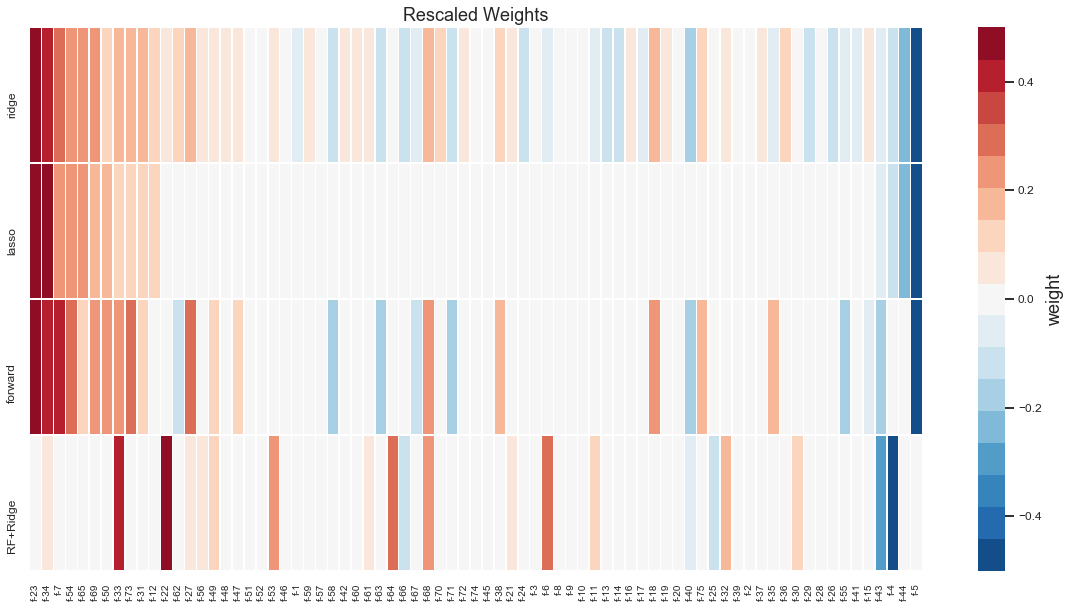

In [34]:
plt.rc('ytick', labelsize=12)
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=10)
df_ = all_w.sort_values('lasso', ascending=False).T

cmap = sns.color_palette("RdBu_r", 17)
sns.heatmap(df_, cmap=cmap, annot=False, linewidths=.5, cbar_kws={'label': 'weight'}, vmax=0.5, vmin=-0.5)
plt.title('Rescaled Weights')

plt.show()
#plt.savefig('feats_comparison.png')

As seen from above, the ridge, LASSO and forward selection procedures yield similar high weight features, while Random Forest chooses a bunch of moderate weight features that are score lower by other methods.